# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

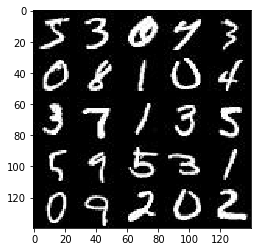

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

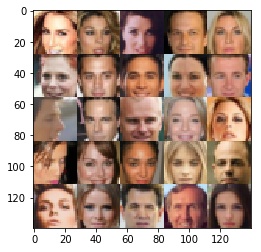

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                  name='real_input')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.3
        
        #Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        #Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        #Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        #Layer 4
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """      
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.3
        if is_train is True:
            drop = 0.5
        else:
            drop = 1.0
            
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        g2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(logits, training=is_train)
        out = tf.tanh(batch_norm3)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode,print_every=10, 
          show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #build network
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],
                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1
                x = x*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 12.3811
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.4697
Epoch 1/2... Discriminator Loss: 2.9523... Generator Loss: 0.4123
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 1.7807... Generator Loss: 1.2658
Epoch 1/2... Discriminator Loss: 1.6674... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 1.8587... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 1.6079... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 1.8310... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.8375


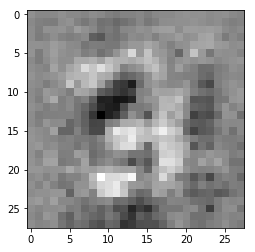

Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.6156... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 1.1950
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 1.0431
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 1.8380... Generator Loss: 0.4082
Epoch 1/2... Discriminator Loss: 1.9588... Generator Loss: 0.3912
Epoch 1/2... Discriminator Loss: 1.9625... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 2.1563... Generator Loss: 0.3596


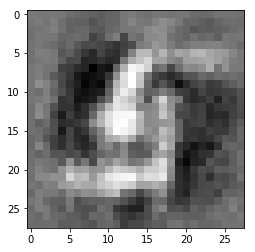

Epoch 1/2... Discriminator Loss: 1.7740... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 1.7457... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 2.1843... Generator Loss: 0.3722
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 1.1460
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 2.5037... Generator Loss: 0.3541
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 2.1068... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.5139... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 2.0467... Generator Loss: 0.3941


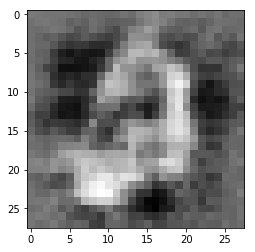

Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 2.4361... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 1.4488
Epoch 1/2... Discriminator Loss: 1.7338... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 2.3885... Generator Loss: 0.3653
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.5053


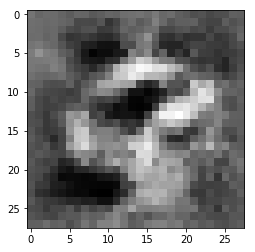

Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 1.2834
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 1.1891
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 2.6583... Generator Loss: 0.3810


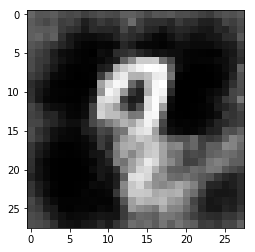

Epoch 1/2... Discriminator Loss: 2.1459... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 2.1683... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 1.7307... Generator Loss: 1.8954
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.4239


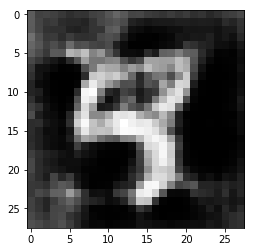

Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.2939
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.7163... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 1.5372... Generator Loss: 0.5301
Epoch 1/2... Discriminator Loss: 2.4095... Generator Loss: 2.3170
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.0148
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.7079... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.9592... Generator Loss: 0.4117


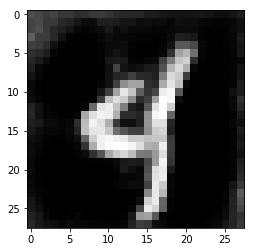

Epoch 1/2... Discriminator Loss: 1.8102... Generator Loss: 0.4637
Epoch 1/2... Discriminator Loss: 1.6737... Generator Loss: 0.5151
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 2.9035... Generator Loss: 0.3499
Epoch 1/2... Discriminator Loss: 1.8272... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.8764... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 1.7250... Generator Loss: 0.4855


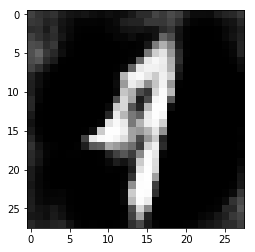

Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 2.2125
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.1978
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 1.6579
Epoch 1/2... Discriminator Loss: 1.9669... Generator Loss: 0.4206
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.6006
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.7632


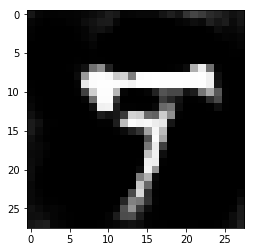

Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 1.7951
Epoch 1/2... Discriminator Loss: 1.6325... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 2.0427... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.8237... Generator Loss: 0.4385
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.5940... Generator Loss: 0.5450
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 1.6750... Generator Loss: 0.5066


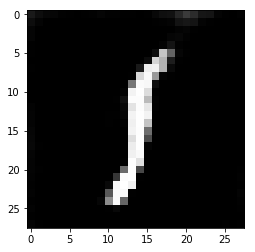

Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.0688
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 2.0942... Generator Loss: 0.4850
Epoch 2/2... Discriminator Loss: 2.0709... Generator Loss: 0.3928
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.5825... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.7626


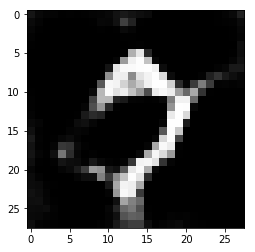

Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 1.3440
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 1.4211... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 1.8796... Generator Loss: 0.5056
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.3056


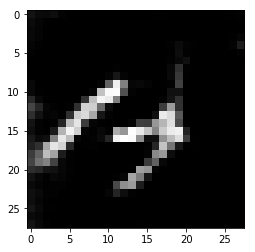

Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.8764... Generator Loss: 2.4832
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 0.7505... Generator Loss: 1.8406
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 1.3826
Epoch 2/2... Discriminator Loss: 2.2702... Generator Loss: 0.4000
Epoch 2/2... Discriminator Loss: 1.9941... Generator Loss: 0.4500
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.8345


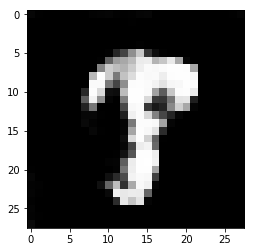

Epoch 2/2... Discriminator Loss: 2.0888... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 1.4601... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 1.6947
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.2392
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.9956
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.3011... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 2.6671
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 0.8704


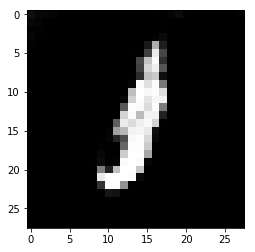

Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.6073
Epoch 2/2... Discriminator Loss: 2.1069... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 1.9267... Generator Loss: 0.5125
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.2484
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.7952


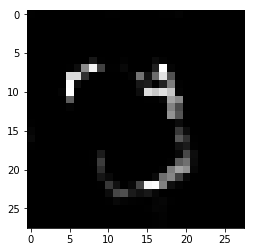

Epoch 2/2... Discriminator Loss: 1.5557... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.7834
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 1.3855
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 2.3205... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 2.3738... Generator Loss: 0.3947
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.2763


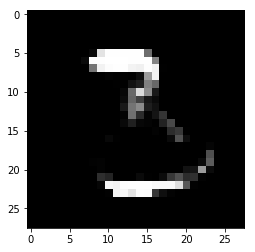

Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.2300
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.3032
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.5207
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 0.9347
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 1.1924
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 4.2971... Generator Loss: 6.0074


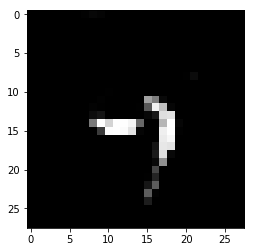

Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.5195... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.3564
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 1.6337
Epoch 2/2... Discriminator Loss: 0.8722... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 2.4307... Generator Loss: 0.3988
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 1.1192


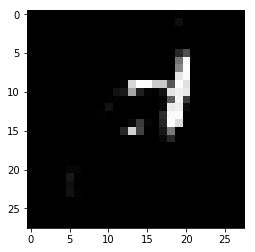

Epoch 2/2... Discriminator Loss: 1.1111... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 2.8419
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.5645
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 2.6678
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.2819


In [49]:
batch_size = 64
z_dim = 500
learning_rate = 0.0008
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.2198... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 3.0523... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 9.6788
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.0195
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 3.2216
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 2.2792... Generator Loss: 5.0179


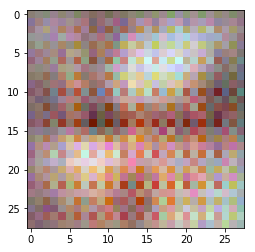

Epoch 1/1... Discriminator Loss: 4.2202... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 2.3794
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 3.1840... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 2.0083
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 2.0880


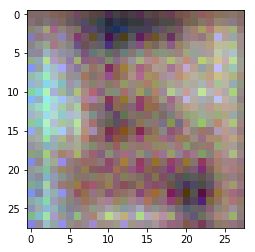

Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.2768
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 2.1257... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.0224


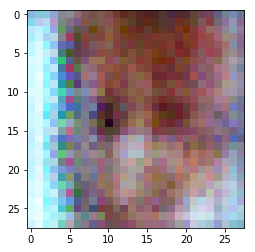

Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 2.8295... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 1.6619... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.7348


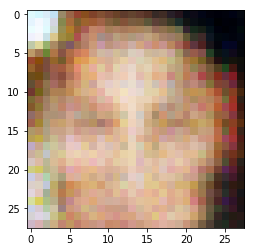

Epoch 1/1... Discriminator Loss: 3.9961... Generator Loss: 0.3843
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.8488
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 3.7523... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 4.6924... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.6826... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 2.3032... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 2.7784... Generator Loss: 0.3292


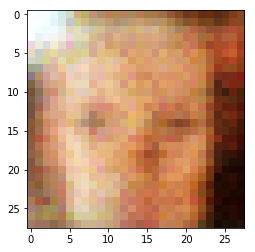

Epoch 1/1... Discriminator Loss: 1.8451... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 2.9914... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 2.0599... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 2.0434... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 3.3670... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 3.8303... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 2.3057... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 2.0912... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 3.5634... Generator Loss: 0.3576


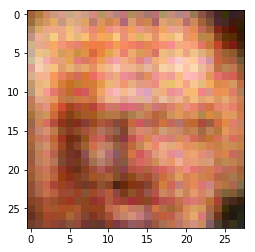

Epoch 1/1... Discriminator Loss: 2.6524... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 2.6264... Generator Loss: 0.3506
Epoch 1/1... Discriminator Loss: 2.2072... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 2.0810... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 3.2695... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 2.3860... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 2.7195... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 2.3763... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 3.0219... Generator Loss: 0.3353


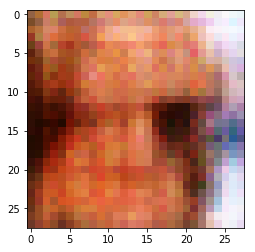

Epoch 1/1... Discriminator Loss: 1.8938... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.8471... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 1.7137... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.8759... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 2.1315... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 2.3088... Generator Loss: 0.5721


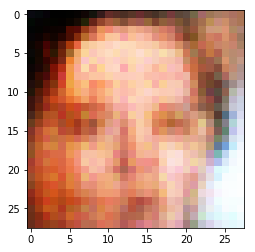

Epoch 1/1... Discriminator Loss: 2.2178... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.8953... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.8456... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 2.5249... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 2.0240... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 2.0946... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 2.8455... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 1.9419... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 2.6906... Generator Loss: 0.3350


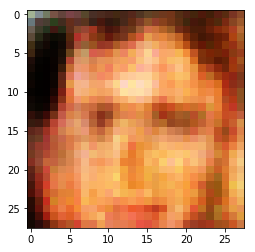

Epoch 1/1... Discriminator Loss: 2.6506... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 2.5859... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 2.7620... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 2.3312... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 2.8884... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 2.1473... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 2.0330... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 0.5231


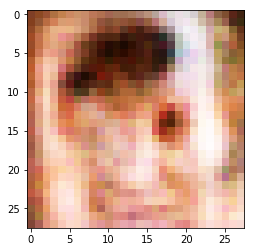

Epoch 1/1... Discriminator Loss: 2.4531... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 2.5702... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 2.6917... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 2.9366... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 2.4272... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 3.0137... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 2.6677... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 2.3123... Generator Loss: 0.8536


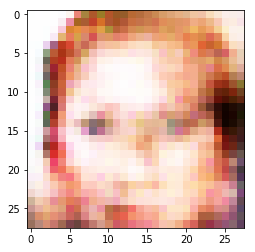

Epoch 1/1... Discriminator Loss: 2.2239... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 2.2495... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 2.3177... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 2.9025... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 2.3839... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 2.3771... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.7265... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 2.8745... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 1.8359... Generator Loss: 0.4321


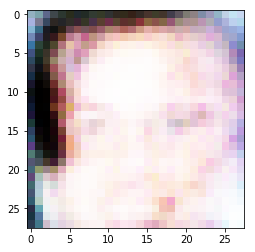

Epoch 1/1... Discriminator Loss: 2.6560... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 2.1263... Generator Loss: 0.3774
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 2.5439... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 2.5345... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.7838... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.7300... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7287


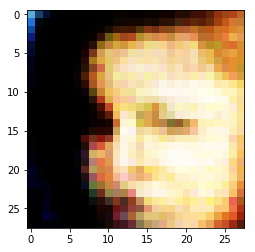

Epoch 1/1... Discriminator Loss: 1.8253... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 3.3880... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 2.1631... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 2.5182... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.9945... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 2.2588
Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.9499... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.6957... Generator Loss: 0.8873


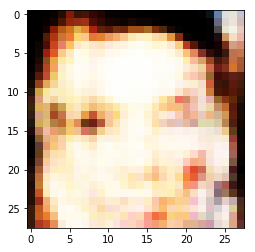

Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 2.0140... Generator Loss: 0.4163
Epoch 1/1... Discriminator Loss: 2.5471... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 2.3210... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 3.2576... Generator Loss: 0.3480
Epoch 1/1... Discriminator Loss: 2.8232... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 2.0939... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.9090... Generator Loss: 0.4621


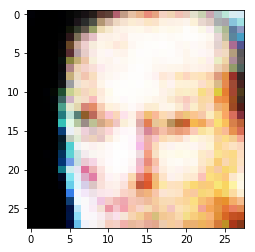

Epoch 1/1... Discriminator Loss: 3.5545... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 2.3879... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 3.0745... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 2.8035... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 1.6928... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 2.3518... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.9768


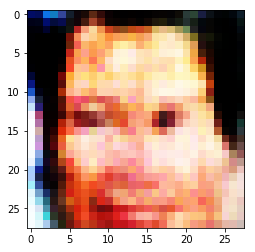

Epoch 1/1... Discriminator Loss: 2.1508... Generator Loss: 0.3849
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 2.7155... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 2.5058... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 2.9932... Generator Loss: 0.3430
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 2.9307... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 2.0014... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.5854


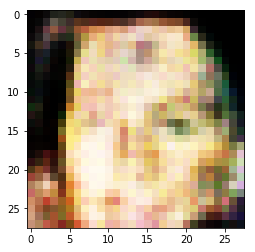

Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 2.5066... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 3.3019... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 2.0123... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 2.1392... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8692


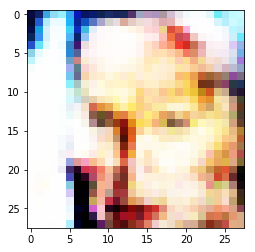

Epoch 1/1... Discriminator Loss: 1.9809... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 3.6258... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 2.3100... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 2.6582... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 1.8808... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 2.6020... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.9983


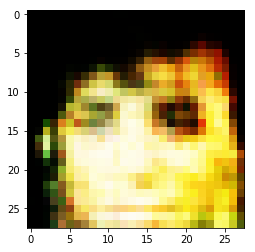

Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 3.2200... Generator Loss: 0.3470
Epoch 1/1... Discriminator Loss: 2.0019... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 2.1077... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 3.4883... Generator Loss: 0.3589
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.7017
Epoch 1/1... Discriminator Loss: 2.8848... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 2.0652... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 2.3832


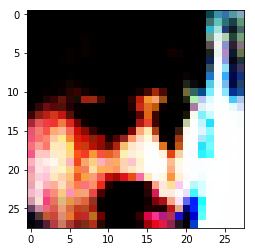

Epoch 1/1... Discriminator Loss: 1.7089... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 2.9664... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 2.6303... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 3.1304... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 1.7417... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 2.7295... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.7065... Generator Loss: 0.5494


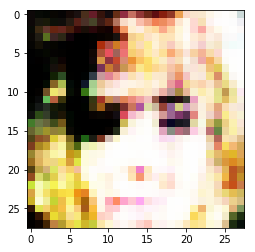

Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.9217... Generator Loss: 1.9699
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 2.0245... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 3.1954... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.7690
Epoch 1/1... Discriminator Loss: 3.6397... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.4900


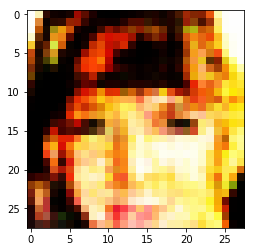

Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 3.0454... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 2.5937... Generator Loss: 0.3454
Epoch 1/1... Discriminator Loss: 2.2174... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 3.9264... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 2.7567... Generator Loss: 0.3567
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 1.9994... Generator Loss: 1.3374


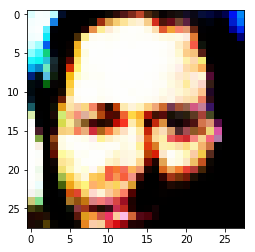

Epoch 1/1... Discriminator Loss: 2.1503... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 3.7063... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.1616
Epoch 1/1... Discriminator Loss: 2.2236... Generator Loss: 0.3801
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6386


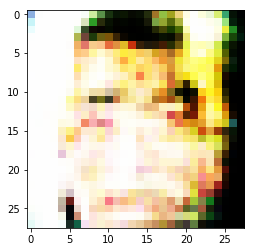

Epoch 1/1... Discriminator Loss: 2.7608... Generator Loss: 0.3565
Epoch 1/1... Discriminator Loss: 2.4026... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 2.4784... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 2.1835... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 2.3076... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 2.3543... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.9270... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6717


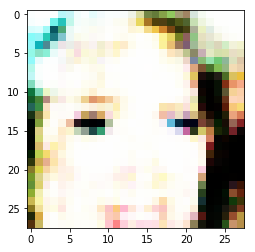

Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 2.0295... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 2.1003... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.8341... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.8999... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 4.0357... Generator Loss: 0.3936


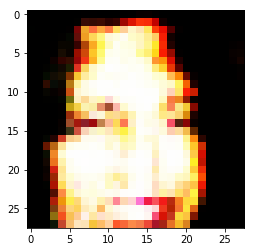

Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 2.0768... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 2.2507... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 3.4898... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 3.4246... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 2.0539... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 3.9644... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 0.9947


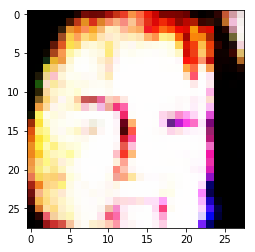

Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.7772... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 2.3394... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.6447... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 2.6572... Generator Loss: 0.3801
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 3.1257... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 2.2513... Generator Loss: 0.3915


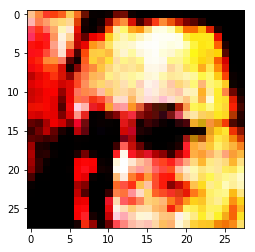

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 2.3539... Generator Loss: 0.3846
Epoch 1/1... Discriminator Loss: 3.9645... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.9957... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 2.5246... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 2.4918... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6003


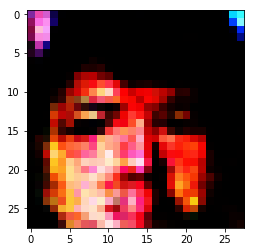

Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 2.6977... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 3.5245... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 3.2654... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.7925... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.6386... Generator Loss: 0.6006


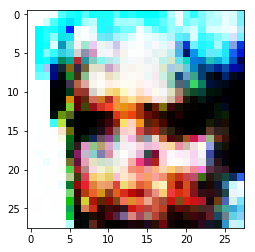

Epoch 1/1... Discriminator Loss: 2.1048... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 2.3335... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 4.2746... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 2.5393... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 2.4931... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 3.0380... Generator Loss: 0.3556


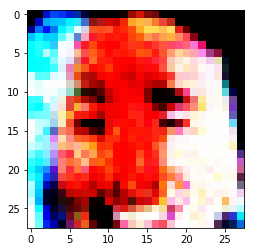

Epoch 1/1... Discriminator Loss: 3.6540... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 3.8633... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 2.6281... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.7265... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.6925... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 4.3937... Generator Loss: 0.4156


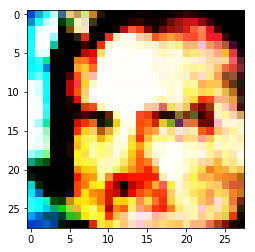

Epoch 1/1... Discriminator Loss: 1.8671... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.8541... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 2.1026... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 3.3151... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 3.6177... Generator Loss: 0.3740


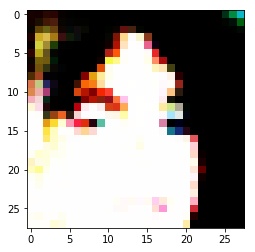

Epoch 1/1... Discriminator Loss: 2.9059... Generator Loss: 0.3586
Epoch 1/1... Discriminator Loss: 2.9653... Generator Loss: 0.3480
Epoch 1/1... Discriminator Loss: 2.3027... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 3.6289... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 2.1059... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.4424
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.2413


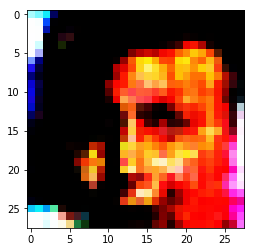

Epoch 1/1... Discriminator Loss: 2.8059... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.6002
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 2.8891... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 2.5825... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 2.0641... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.7164


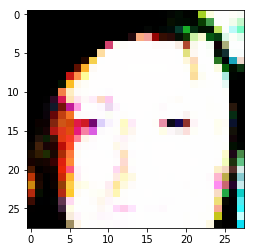

Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.8863
Epoch 1/1... Discriminator Loss: 1.7996... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 2.2277... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9292


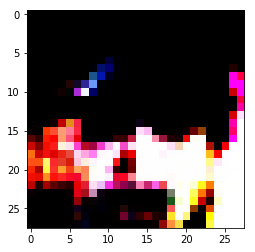

Epoch 1/1... Discriminator Loss: 2.1230... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.9433... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 2.8816... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.6828
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.8486... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.4439


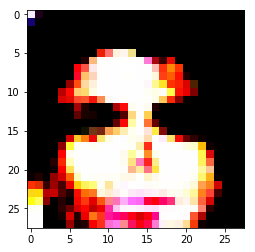

Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 2.5869... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 3.7778... Generator Loss: 0.3700
Epoch 1/1... Discriminator Loss: 3.2756... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 2.0074... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 2.6811... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.8700... Generator Loss: 2.1844
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.8119


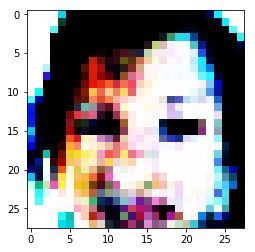

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.8250... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 2.7633... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.1742


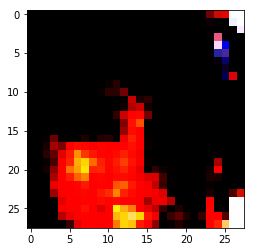

Epoch 1/1... Discriminator Loss: 2.1543... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.2528
Epoch 1/1... Discriminator Loss: 3.0312... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 3.2632... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 2.4269... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.8433


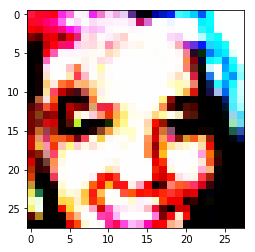

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.8630... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 2.2889... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.9150... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 3.0247... Generator Loss: 0.3329


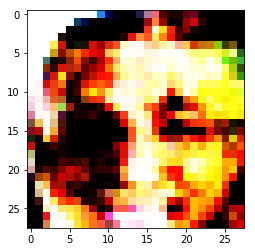

Epoch 1/1... Discriminator Loss: 2.1804... Generator Loss: 0.3978
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 2.5182... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 1.6779
Epoch 1/1... Discriminator Loss: 2.9139... Generator Loss: 0.3492
Epoch 1/1... Discriminator Loss: 3.6439... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.9422... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 2.0135... Generator Loss: 0.4347


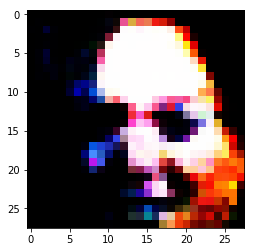

Epoch 1/1... Discriminator Loss: 3.5434... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.5062
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.6178
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.9745... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 2.2070... Generator Loss: 0.3900


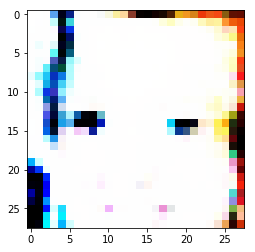

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.9525... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 2.4497... Generator Loss: 0.3448
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 2.3060... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 2.1586... Generator Loss: 0.4262


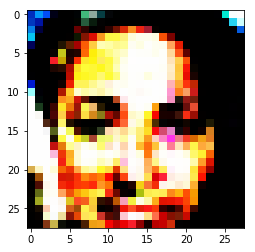

Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 2.3848... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 2.2423... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 0.5438... Generator Loss: 1.9491
Epoch 1/1... Discriminator Loss: 2.0038... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.5419


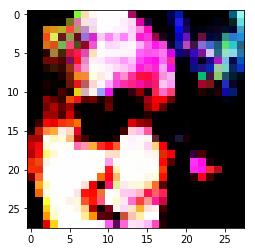

Epoch 1/1... Discriminator Loss: 2.7970... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 1.9598
Epoch 1/1... Discriminator Loss: 2.2631... Generator Loss: 1.5637
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 3.0143... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 3.9893... Generator Loss: 0.3901


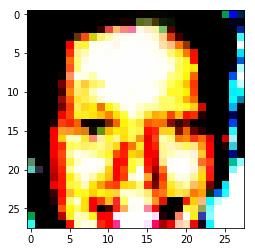

Epoch 1/1... Discriminator Loss: 2.4036... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 1.8739... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.7488
Epoch 1/1... Discriminator Loss: 1.7012... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.5713... Generator Loss: 1.9004
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.6940
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8856


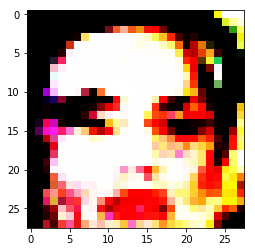

Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 1.8285
Epoch 1/1... Discriminator Loss: 2.0342... Generator Loss: 1.7682
Epoch 1/1... Discriminator Loss: 1.8384... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 2.4055... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 4.6137... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 2.9558... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.4170
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.5267


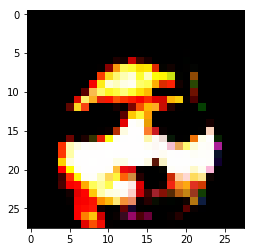

Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 2.2703... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 2.3024... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.4239
Epoch 1/1... Discriminator Loss: 3.6267... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 3.7925... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.8237... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 1.3951


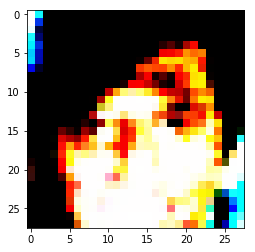

Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 2.2350... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 1.6694... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.2006


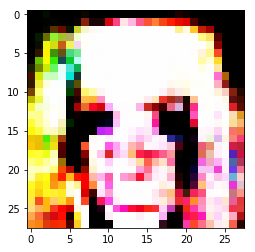

Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 3.8563... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 2.2349... Generator Loss: 0.3819
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.5145
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.1770


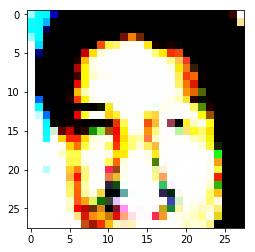

Epoch 1/1... Discriminator Loss: 2.1687... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 3.2968... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 2.2322
Epoch 1/1... Discriminator Loss: 2.4195... Generator Loss: 0.4166
Epoch 1/1... Discriminator Loss: 2.1179... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 1.5776
Epoch 1/1... Discriminator Loss: 2.1282... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 2.1350... Generator Loss: 0.4504


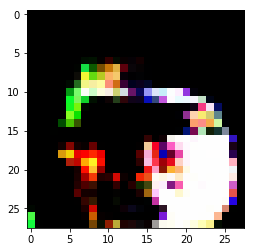

Epoch 1/1... Discriminator Loss: 1.6599... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 1.7171... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.1843
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.8387
Epoch 1/1... Discriminator Loss: 3.5249... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 1.8195... Generator Loss: 1.6432
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 1.8668... Generator Loss: 0.4566


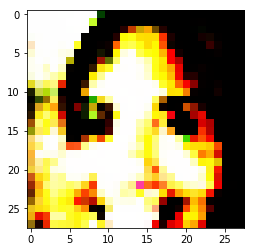

Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.5160
Epoch 1/1... Discriminator Loss: 2.0268... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 2.6107... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 3.5087... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 2.1237... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 2.0135... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.8109... Generator Loss: 0.4818


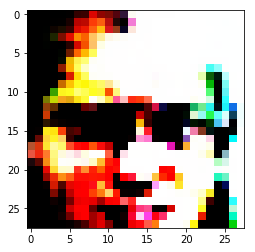

Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.9729... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.8017... Generator Loss: 1.1065


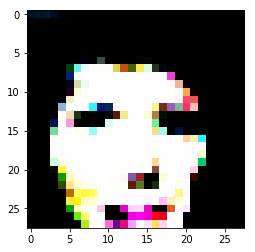

Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 2.0821... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.6973... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 2.8997... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 2.7250... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.9658... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.1023


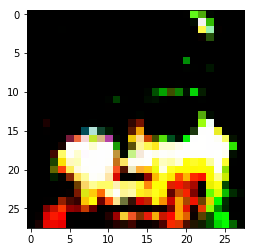

Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 2.0993
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.3777
Epoch 1/1... Discriminator Loss: 3.8236... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 3.5353... Generator Loss: 0.3535
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.9764... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 2.2655... Generator Loss: 0.3765


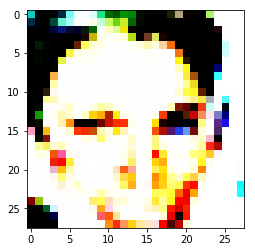

Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.6118
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 2.0301
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.7132


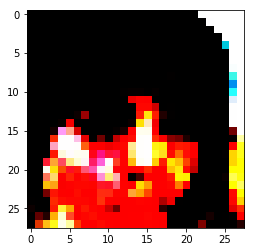

Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.9627... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.5109
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.7422
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 2.2691... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.1616


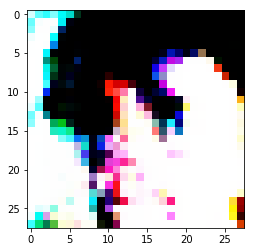

Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 2.5837
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 2.1094
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.7044
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 2.0531
Epoch 1/1... Discriminator Loss: 2.5434... Generator Loss: 2.5919
Epoch 1/1... Discriminator Loss: 2.1528... Generator Loss: 0.7987


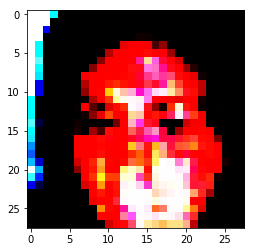

Epoch 1/1... Discriminator Loss: 3.3833... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 2.2929... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 1.9860
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.2948
Epoch 1/1... Discriminator Loss: 2.0258... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 1.8607
Epoch 1/1... Discriminator Loss: 1.6739... Generator Loss: 0.5867


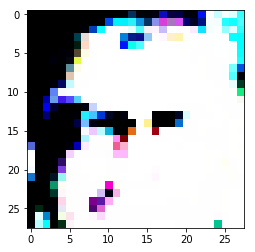

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 2.3338... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.0299
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 2.3030
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.7000
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 3.1103
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 2.7588... Generator Loss: 0.3709


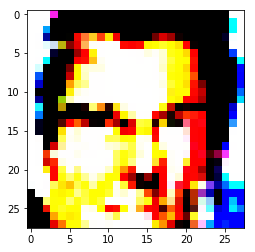

Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.7695
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.5212... Generator Loss: 1.9334
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 2.8748... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6354


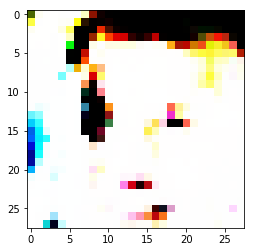

Epoch 1/1... Discriminator Loss: 2.2769... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 2.0596... Generator Loss: 0.4061


In [14]:
batch_size = 32
z_dim = 2048
learning_rate = 0.0005
beta1 = 0.1



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.